In [215]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

%precision % .4f

import warnings

warnings.filterwarnings('ignore')

### Описание датасета
Сам [датасет](https://github.com/rustam-azimov/ml-course/tree/main/data/heart_disease)

Описание датасета:
Основные признаки:

- age - возраст
- sex - пол
- cp - тип боли в груди
- trestbps - давление в покое
- chol - холестерин
- fbs - (сахар в крови > 120) (1 = true; 0 = false)
- restecg - результаты электрокардиографии в покое
- thalach - максимальная частота сердечных сокращений
- exang - стенокардия, вызванная физической нагрузкой (1 = yes; 0 = no)
- oldpeak - депрессия сегмента ST, вызванная физической нагрузкой относительно покоя
- slope - наклон пика сегмента ST при максимальной физической нагрузке
- ca - количество крупных сосудов (0-3), окрашенных флурозопией
- thal - 3 = норма; 6 = фиксированный дефект; 7 = обратимый дефект
- target - наличие заболевания (1=yes, 0=no)

Необходимо решить задачу классификации, предсказать целевой признак `target`.

In [216]:
df = pd.read_csv('/kaggle/input/heart-csv/heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [217]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

В датасете нет пропущенных значений.

In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


##### Пол (0 = женский, 1 = мужской)

<Axes: xlabel='sex', ylabel='count'>

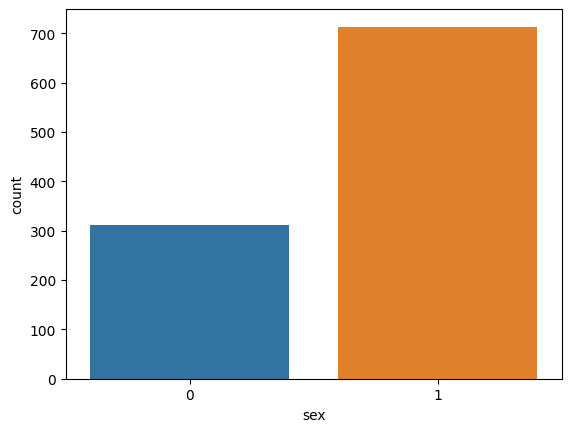

In [219]:
sns.countplot(x='sex', data=df)

В выборке мужчин больше чем в два раза больше, чем женщин.

<Axes: xlabel='sex', ylabel='target'>

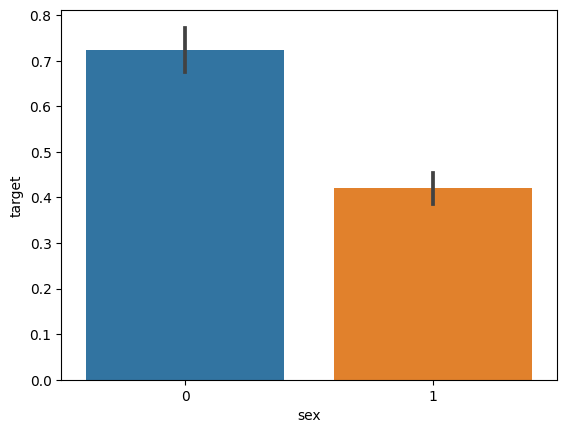

In [220]:
sns.barplot(x='sex', y="target", data=df)

При этом почти у всех женщин из выборки заболевание сердца имеется, в то время как у мужчин 50/50.

##### Возраст

<Axes: xlabel='age'>

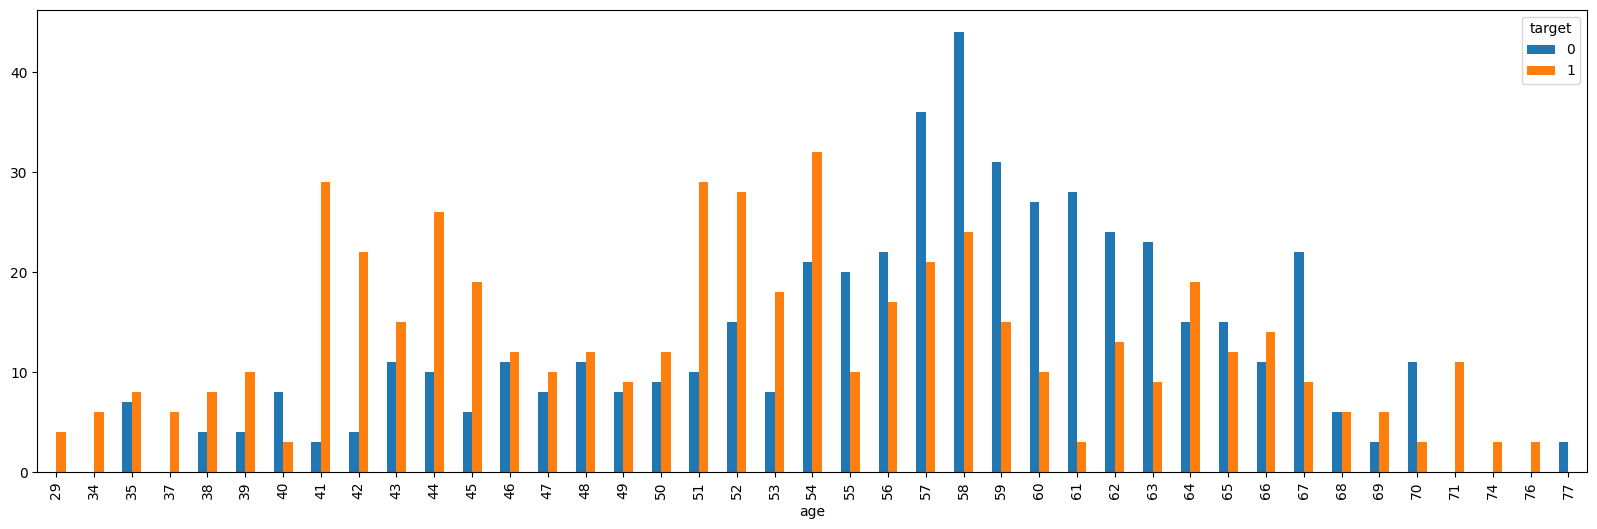

In [221]:
pd.crosstab(df.age, df.target).plot(kind="bar", figsize=(20, 6))

##### Тип боли в груди

<Axes: xlabel='cp'>

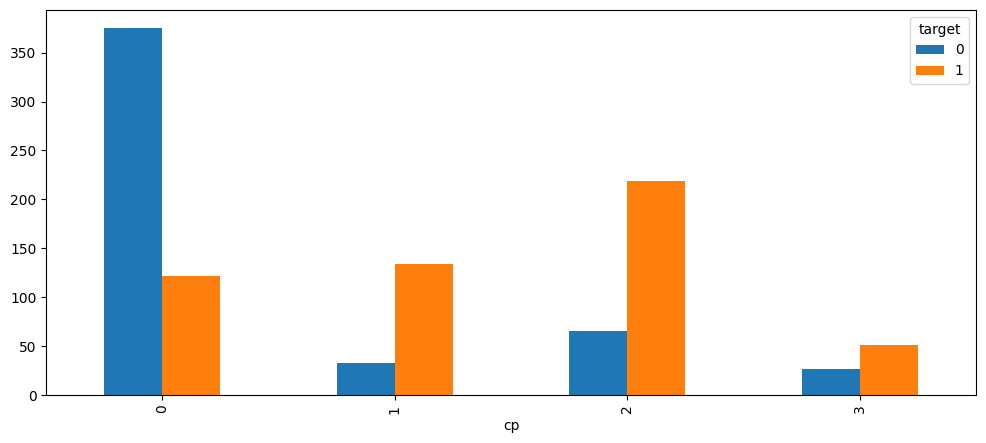

In [222]:
pd.crosstab(df.cp, df.target).plot(kind="bar", figsize=(12, 5))

Чаще всего обращаются с типом боли под номером 0, но при этом у них заболевания не выявлено.

Проверим, каким признаки больше всего коррелируют с целевым.

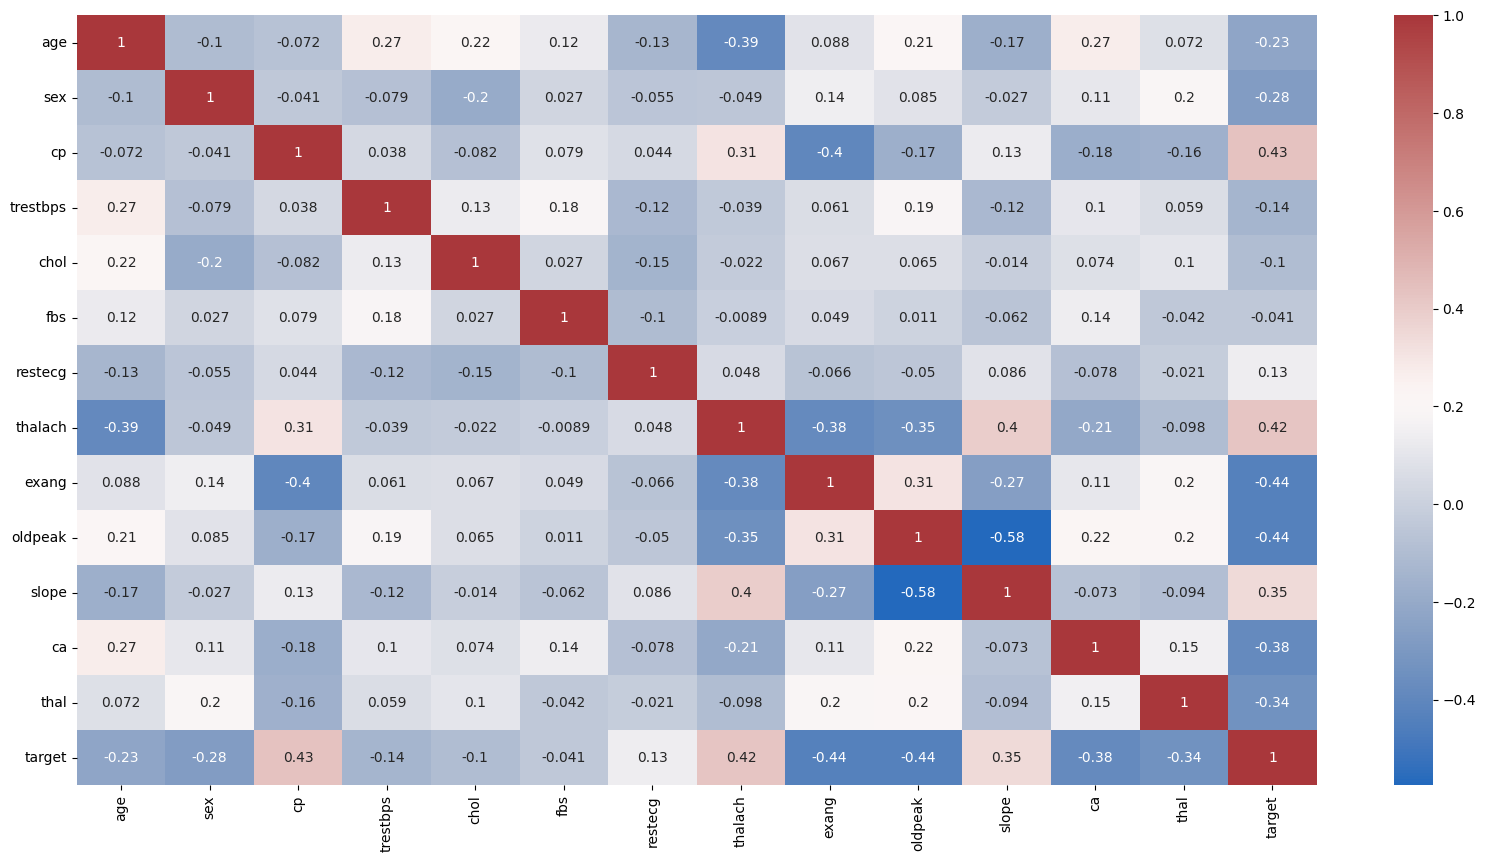

In [223]:
sns.heatmap(df.corr(), annot=True, cmap="vlag")
fig = plt.gcf()
fig.set_size_inches(20, 10)
plt.show()

Согласно графику, больше всего наличие заболевания коррелирует с типом боли в груди, максимальной частотой сердечных сокращений, стенокардией при физических нагрузках и депрессией сегмента ST при физических нагрузках.

### Реализация

In [224]:
from sklearn.base import BaseEstimator, ClassifierMixin


class KNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, neighbors=3):
        self.neighbors = neighbors

    def fit(self, X, y):
        self.X_, self.y_ = X, y
        return self

    def predict(self, X):
        result = np.empty((X.shape[0],), dtype=self.y_.dtype)
        for i, x in enumerate(X):
            dists = np.linalg.norm(self.X_ - x, axis=1)
            sorted_dists_idx = np.argsort(dists)
            neighbor_classes = self.y_[sorted_dists_idx][:self.neighbors]
            elems, counts = np.unique(neighbor_classes, return_counts=True)
            result[i] = elems[np.argmax(counts)]

        return result

### Подбор наилучших гиперпараметров и кросс-валидация

In [225]:
from sklearn.model_selection import train_test_split

X = df.drop(['target'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=79)
X_train, X_test, y_train, y_test = X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()

In [226]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


def train(estimator, grid, scoring):
    model = Pipeline([("scaler", StandardScaler()), ("estimator", estimator)])
    param_grid = {f"estimator__{name}": val for name, val in grid.items()}
    grid_cv = GridSearchCV(
        model,
        param_grid,
        scoring=scoring,
    )
    grid_cv.fit(X_train, y_train)
    print("Лучшие параметры - ", grid_cv.best_params_)
    print('Лучший score - ', grid_cv.best_score_)

    ax = ConfusionMatrixDisplay.from_estimator(
        grid_cv.best_estimator_,
        X_test,
        y_test,
        cmap="Blues",
    ).ax_
    ax.set_title("Confusion matrix")
    ax.plot()

Лучшие параметры -  {'estimator__neighbors': 3}
Лучший score -  0.9199328107502799


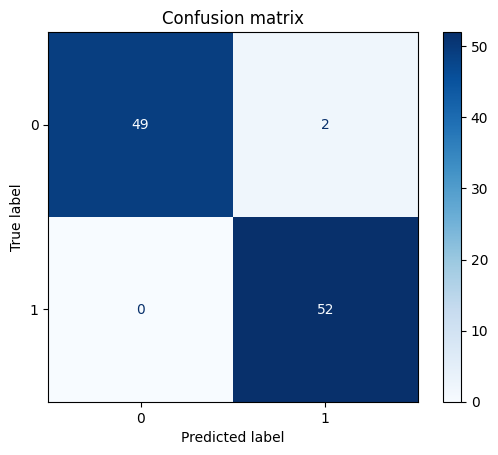

In [227]:
train(KNNClassifier(),
      {"neighbors": [2, 3, 5, 7]}, "recall")

Лучшие параметры -  {'estimator__n_neighbors': 3}
Лучший score -  0.9199328107502799


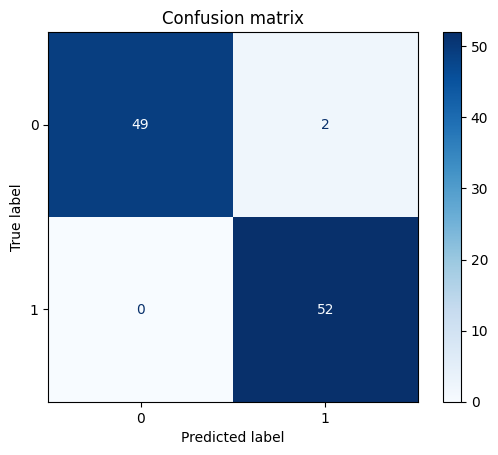

In [228]:
from sklearn.neighbors import KNeighborsClassifier

train(
    KNeighborsClassifier(),
    { "n_neighbors": [2, 3, 5, 7]}, "recall")

Лучшие параметры -  {'estimator__C': 0.1, 'estimator__tol': 1e-06}
Лучший score -  0.9030011198208285


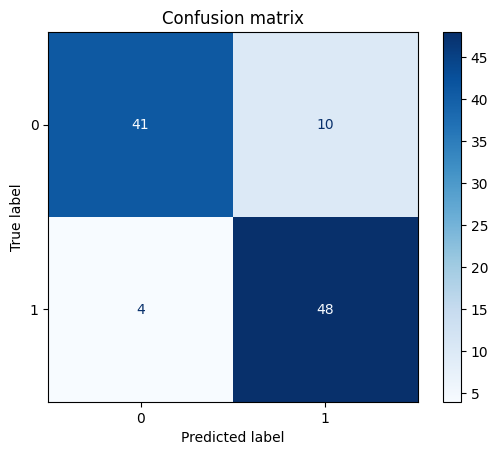

In [229]:
from sklearn.linear_model import LogisticRegression

train(
    LogisticRegression(), 
    {
        "tol": [1e-6, 1e-5, 1e-4],
        "C": [0.1, 0.4, 0.7, 1],
        
    },
    "recall"
)

Лучшие параметры -  {'estimator__C': 0.01, 'estimator__coef0': 1, 'estimator__gamma': 'scale', 'estimator__kernel': 'sigmoid', 'estimator__tol': 1e-06}
Лучший score -  0.9767749160134379


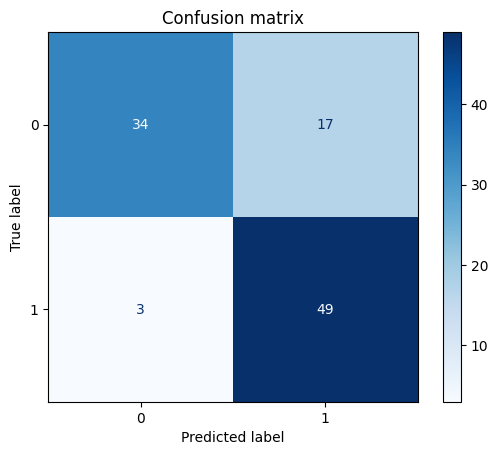

In [230]:
from sklearn.svm import SVC

train(
    SVC(),
    {
        "C": [0.01, 0.1, 1],
        "kernel": ["linear", "sigmoid"],
        "gamma": ["scale", "auto"],
        "coef0": [0, 1],
        "tol": [1e-6, 1e-4],
    },
    "recall"
)

Лучшие параметры -  {'estimator__var_smoothing': 0.001}
Лучший score -  0.8650839865621499


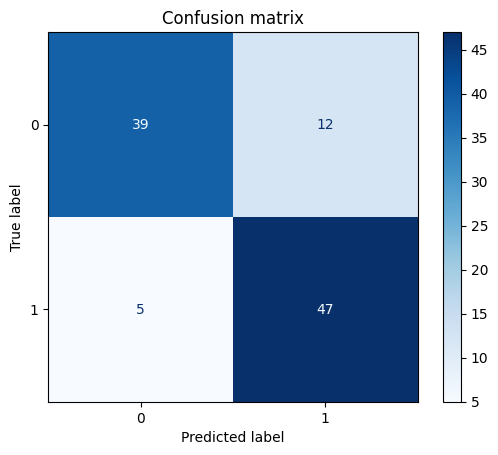

In [231]:
from sklearn.naive_bayes import GaussianNB

train(
    GaussianNB(),
    {
        "var_smoothing": [1e-3, 1e-5, 1e-7]
    },
    "recall"
)

Лучшие параметры -  {'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__max_leaf_nodes': 100, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0, 'estimator__splitter': 'best'}
Лучший score -  1.0


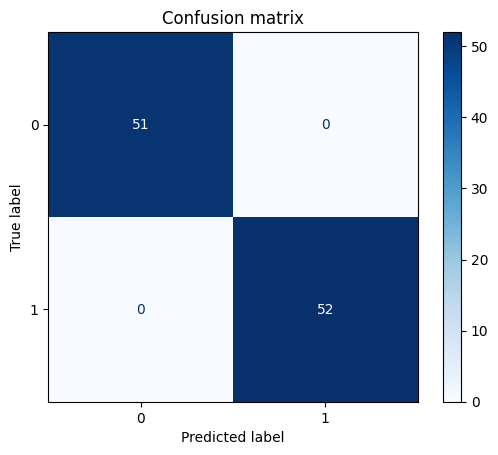

In [232]:
from sklearn.tree import DecisionTreeClassifier

train(
    DecisionTreeClassifier(),
    {
        "criterion": ["gini", "entropy", "log_loss"],
        "splitter": ["best", "random"],
        "max_depth": [None, 100, 400],
        "min_samples_split": [2, 4],
        "min_samples_leaf": [1, 3],
        "min_weight_fraction_leaf": [0, 0.01, 0.1],
        "max_leaf_nodes": [None, 100, 400],
    },
    "recall"
)

### Выводы

1. Все рассмотренные методы классификации достигли хороших результатов на задаче классификации с использованием метрики recall.
2. Наилучшие результаты на данном датасете показали модели Decision Tree, Support Vector Machine (SVM) и KNN, наихудшие (хотя все еще приемлемые) - Gaussian Naive Bayes.